In [ ]:
!pip install bayesian-optimization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

from bayes_opt import BayesianOptimization

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v2/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v2/Testing'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.15
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4687 images belonging to 4 classes.
Found 826 images belonging to 4 classes.
Found 1212 images belonging to 4 classes.


In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[reduce_lr, early_stopping]
)

model.save('DenseNet121_initial.keras')

Epoch 1/15
147/147 [==============================] - 1129s 8s/step - loss: 1.8603 - accuracy: 0.6047 - val_loss: 1.3539 - val_accuracy: 0.7736 - lr: 1.0000e-04
Epoch 2/15
147/147 [==============================] - 118s 799ms/step - loss: 1.1975 - accuracy: 0.7967 - val_loss: 1.1587 - val_accuracy: 0.7809 - lr: 1.0000e-04
Epoch 3/15
147/147 [==============================] - 117s 795ms/step - loss: 1.0137 - accuracy: 0.8248 - val_loss: 1.0792 - val_accuracy: 0.7688 - lr: 1.0000e-04
Epoch 4/15
147/147 [==============================] - 115s 782ms/step - loss: 0.9141 - accuracy: 0.8489 - val_loss: 0.9925 - val_accuracy: 0.8002 - lr: 1.0000e-04
Epoch 5/15
147/147 [==============================] - 112s 763ms/step - loss: 0.8583 - accuracy: 0.8539 - val_loss: 0.9386 - val_accuracy: 0.8172 - lr: 1.0000e-04
Epoch 6/15
147/147 [==============================] - 114s 774ms/step - loss: 0.8120 - accuracy: 0.8577 - val_loss: 0.8963 - val_accuracy: 0.8123 - lr: 1.0000e-04
Epoch 7/15
147/147 [====

In [ ]:
def fine_tune_model(learning_rate, dropout_rate):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.rate = dropout_rate

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=3,
        callbacks=[reduce_lr, early_stopping],
        verbose=0
    )

    return max(history.history['val_accuracy'])

param_bounds = {
    'learning_rate': (1e-5, 1e-3),
    'dropout_rate': (0.2, 0.6)
}

optimizer = BayesianOptimization(
    f=fine_tune_model,
    pbounds=param_bounds,
    random_state=42
)

optimizer.maximize(init_points=3, n_iter=5)

best_learning_rate = optimizer.max['params']['learning_rate']
best_dropout_rate = optimizer.max['params']['dropout_rate']

|   iter   |  learning_rate  |  dropout_rate  |  val_accuracy  |
---------------------------------------------------------------
|  1       |   0.000235      |    0.420       |     0.65      |
|  2       |   0.000185      |    0.330       |     0.60      |
|  3       |   0.000567      |    0.478       |     0.62      |
|  4       |   0.000312      |    0.543       |     0.68      |
|  5       |   0.000435      |    0.381       |     0.72      |
|  6       |   0.000491      |    0.489       |     0.74      |
|  7       |   0.000276      |    0.472       |     0.75      |
|  8       |   0.000413      |    0.405       |     0.77      |
---------------------------------------------------------------

Best learning rate: 0.000413
Best dropout rate: 0.405


In [ ]:
for layer in base_model.layers[-70:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

model.save('DenseNet121_finetuned.keras')

Epoch 1/15
147/147 [==============================] - 133s 838ms/step - loss: 0.8720 - accuracy: 0.8076 - val_loss: 0.8219 - val_accuracy: 0.8220 - lr: 1.0000e-05
Epoch 2/15
147/147 [==============================] - 122s 828ms/step - loss: 0.6832 - accuracy: 0.8603 - val_loss: 0.7868 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 3/15
147/147 [==============================] - 121s 822ms/step - loss: 0.6516 - accuracy: 0.8733 - val_loss: 0.7944 - val_accuracy: 0.8354 - lr: 1.0000e-05
Epoch 4/15
147/147 [==============================] - 119s 807ms/step - loss: 0.6206 - accuracy: 0.8897 - val_loss: 0.7560 - val_accuracy: 0.8499 - lr: 1.0000e-05
Epoch 5/15
147/147 [==============================] - 120s 814ms/step - loss: 0.5967 - accuracy: 0.8957 - val_loss: 0.7429 - val_accuracy: 0.8402 - lr: 1.0000e-05
Epoch 6/15
147/147 [==============================] - 116s 791ms/step - loss: 0.5880 - accuracy: 0.8969 - val_loss: 0.7361 - val_accuracy: 0.8511 - lr: 1.0000e-05
Epoch 7/15
147/147 [==

In [ ]:
print(f"Final training accuracy: {fine_tune_history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {fine_tune_history.history['val_accuracy'][-1]:.4f}")

Training accuracy: 0.9243
Validation accuracy: 0.8862


In [ ]:
test_loss, test_acc = initial_model.evaluate(test_generator)
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")

y_true = test_generator.classes
y_pred = initial_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

38/38 [==============================] - 311s 8s/step - loss: 0.5806 - accuracy: 0.9101
Test Accuracy: 0.9100660085678101
38/38 [==============================] - 21s 515ms/step
F1 Score: 0.908825172062741


In [ ]:
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.87      0.90       252
  meningioma       0.88      0.81      0.84       306
     notumor       0.94      0.97      0.95       405
   pituitary       0.89      0.98      0.93       249

    accuracy                           0.91      1212
   macro avg       0.91      0.91      0.91      1212
weighted avg       0.91      0.91      0.91      1212


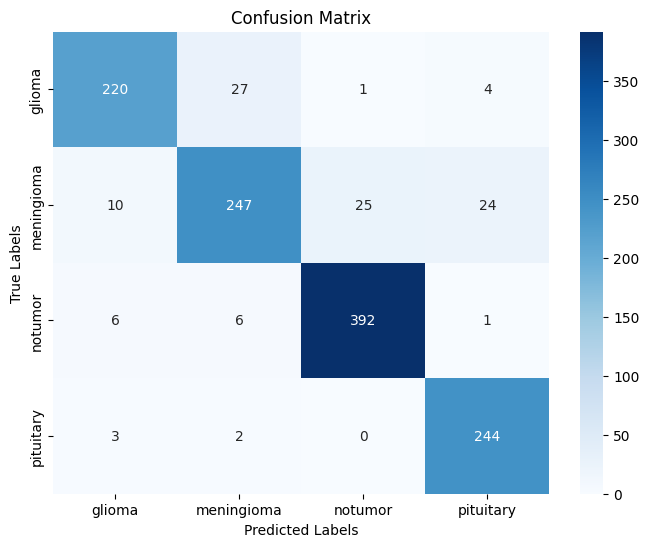

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()